<a href="https://colab.research.google.com/github/abxda/UInternaciones_ML/blob/main/01_Aprendizaje_Supervisado_en_la_Pr%C3%A1ctica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejemplo A — Clasificación con Árbol de Decisión (ID3, didáctico)

En este ejemplo vamos a:
1. Trabajar con un conjunto de datos pequeño (ejemplo bancario: clientes "bueno"/"malo").
2. Calcular entropía y ganancia de información (paso a paso) para elegir la mejor división (ID3).
3. Entrenar un árbol de decisión con scikit-learn y evaluar su rendimiento (matriz de confusión, accuracy, precision, recall).
4. Mostrar la relación entre sobreajuste y validación.

Este notebook es **didáctico**: primero haremos los cálculos manuales (fórmulas) y después usaremos librerías para comparar.

## Datos (ejemplo pequeño)

Usaremos un dataset muy pequeño y manejable para hacer las cuentas a mano. Los atributos son:

- `Empleo`: {'funcionario', 'asalariado', 'autonomo'}
- `Vivienda`: {'propia', 'alquilada', 'otra'}
- `Contrato`: {'indefinido', 'temporal'}
- `Hipoteca`: {'si', 'no'}
- `Clase`: {'bueno', 'malo'}

Los datos son sintéticos para ilustrar ID3. A continuación cargamos los datos en un DataFrame y calculamos entropía / ganancia de información.

In [ ]:
# Código — crea los datos y carga librerías
#!pip install -q scikit-learn pandas matplotlib graphviz

import pandas as pd
import numpy as np
from math import log2
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt

# Dataset sintético más grande y diferenciable
data = [
    ['funcionario','propia','indefinido','no','bueno'],
    ['funcionario','propia','indefinido','si','bueno'],
    ['funcionario','alquilada','indefinido','no','bueno'],
    ['asalariado','alquilada','temporal','si','malo'],
    ['asalariado','propia','temporal','si','malo'],
    ['asalariado','propia','indefinido','no','bueno'],
    ['asalariado','otra','temporal','no','malo'],
    ['autonomo','propia','indefinido','no','bueno'],
    ['autonomo','otra','temporal','si','malo'],
    ['autonomo','propia','temporal','no','bueno'],
    ['funcionario','otra','indefinido','no','bueno'],
    ['asalariado','propia','temporal','no','malo'],
    ['autonomo','alquilada','indefinido','si','malo'],
    ['funcionario','alquilada','temporal','no','bueno'],
    ['asalariado','otra','indefinido','no','bueno'],
]

df = pd.DataFrame(data, columns=['Empleo','Vivienda','Contrato','Hipoteca','Clase'])
df


,Empleo,Vivienda,Contrato,Hipoteca,Clase
0,funcionario,propia,indefinido,no,bueno
1,funcionario,propia,indefinido,si,bueno
2,funcionario,alquilada,indefinido,no,bueno
3,asalariado,alquilada,temporal,si,malo
4,asalariado,propia,temporal,si,malo
5,asalariado,propia,indefinido,no,bueno
6,asalariado,otra,temporal,no,malo
7,autonomo,propia,indefinido,no,bueno
8,autonomo,otra,temporal,si,malo
9,autonomo,propia,temporal,no,bueno


## Entropía (concepto y fórmula)

La entropía para un conjunto con clases $C$ se define como:

$$
H(S) = -\sum_{c \in C} p(c)\log_2 p(c)
$$

donde $p(c)$ es la proporción de ejemplos de la clase $c$ en el conjunto $S$.

A continuación calculamos la entropía del conjunto total y la entropía resultante al dividir por cada atributo (para calcular la ganancia de información).

In [ ]:
# Funciones para entropía y ganancia de información
def entropy(series):
    counts = series.value_counts(normalize=True)
    return -sum(p * log2(p) for p in counts if p > 0)

def info_gain(df, attribute, target='Clase'):
    H_before = entropy(df[target])
    # particionar por valores de attribute
    values = df[attribute].unique()
    H_after = 0.0
    for v in values:
        subset = df[df[attribute]==v]
        H_after += (len(subset) / len(df)) * entropy(subset[target])
    return H_before - H_after

# Entropía total
H_total = entropy(df['Clase'])
print(f"Entropía total H(S) = {H_total:.4f}")

# Ganancias para cada atributo
for attr in ['Empleo','Vivienda','Contrato','Hipoteca']:
    ig = info_gain(df, attr)
    print(f"Ganancia de información IG({attr}) = {ig:.4f}")

Entropía total H(S) = 0.9710
Ganancia de información IG(Empleo) = 0.3370
Ganancia de información IG(Vivienda) = 0.0348
Ganancia de información IG(Contrato) = 0.2783
Ganancia de información IG(Hipoteca) = 0.2490


## Interpretación de resultados (manual)

- Observa cuál atributo tiene mayor ganancia de información: ese será el elegido por ID3 en la raíz.
- Si varios atributos empatan, se pueden usar criterios adicionales (orden, ganancia de ganancia, etc.).
- En datasets pequeños se puede calcular exactamente como hicimos arriba; en la práctica se usa librería.

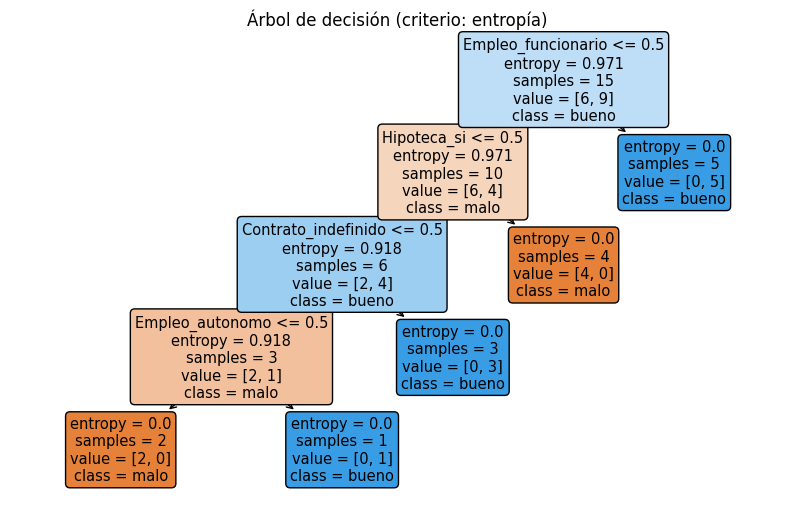

In [ ]:
# Entrenar un árbol de decisión con scikit-learn
# Convertir variables categóricas a dummies (one-hot) para sklearn
X = pd.get_dummies(df.drop(columns='Clase'))
y = df['Clase'].map({'bueno':1, 'malo':0})  # binario 1=buen

# Entrenamos sin separar (demostración) y con separación para validar después
clf = DecisionTreeClassifier(criterion='entropy', random_state=42)
clf.fit(X, y)

# Dibujo del árbol
plt.figure(figsize=(10,6))
plot_tree(clf, feature_names=X.columns, class_names=['malo','bueno'], filled=True, rounded=True)
plt.title("Árbol de decisión (criterio: entropía)")
plt.show()

In [ ]:
# Separación train/test para evaluar (aunque el dataset es muy pequeño — es sólo ilustrativo)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1, stratify=y)
clf2 = DecisionTreeClassifier(criterion='entropy', random_state=1)
clf2.fit(X_train, y_train)
y_pred = clf2.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nMatriz de confusión:\n", confusion_matrix(y_test, y_pred))
print("\nReporte:\n", classification_report(y_test, y_pred, target_names=['malo','bueno']))

Accuracy: 0.4

Matriz de confusión:
 [[1 1]
 [2 1]]

Reporte:
               precision    recall  f1-score   support

        malo       0.33      0.50      0.40         2
       bueno       0.50      0.33      0.40         3

    accuracy                           0.40         5
   macro avg       0.42      0.42      0.40         5
weighted avg       0.43      0.40      0.40         5



## Nota sobre sobreajuste (didáctico)

- Los árboles tienden a ajustar perfectamente al conjunto de entrenamiento si no se podan.
- En datasets pequeños el "overfitting" es muy común: por eso se compara error de entrenamiento vs error de validación.
- Formas de evitarlo: poda, limitar profundidad (`max_depth`), usar validación cruzada, o usar modelos más simples.

# Ejemplo B — Regresión lineal (didáctico)

Objetivos:
1. Generar datos sintéticos para predecir una variable continua (`y`) a partir de `x`.
2. Ajustar una regresión lineal con scikit-learn.
3. Mostrar coeficientes, MSE y R².
4. Validación: train/test y k-fold cross-validation; discusión sobre sesgo/varianza y sobreajuste.

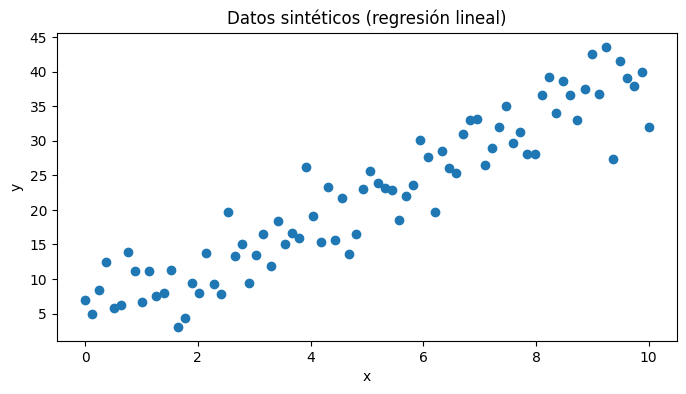

In [ ]:
# Datos sintéticos con ruido (temperatura vs día o precio vs área)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score

np.random.seed(42)
n = 80
X = np.linspace(0, 10, n)
# relación lineal y = 3.5*x + 5 + ruido
y = 3.5 * X + 5 + np.random.normal(scale=4.0, size=n)

# Visualización inicial
plt.figure(figsize=(8,4))
plt.scatter(X, y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Datos sintéticos (regresión lineal)")
plt.show()

# Preparar para sklearn (X debe ser 2D)
X_2d = X.reshape(-1,1)

## Regresión lineal — idea esencial

La regresión lineal busca parámetros β0 (intercepto) y β1 (pendiente) tal que:
y ≈ β1 * x + β0

Se ajustan minimizando la suma de errores cuadrados (MSE). Veremos coeficientes, MSE y R² (coeficiente de determinación).

Coeficiente (pendiente) β1 = 3.638661422867884
Intercepto β0 = 3.5293912913133347
MSE (test) = 11.659195392831377
R² (test) = 0.8805031710742741


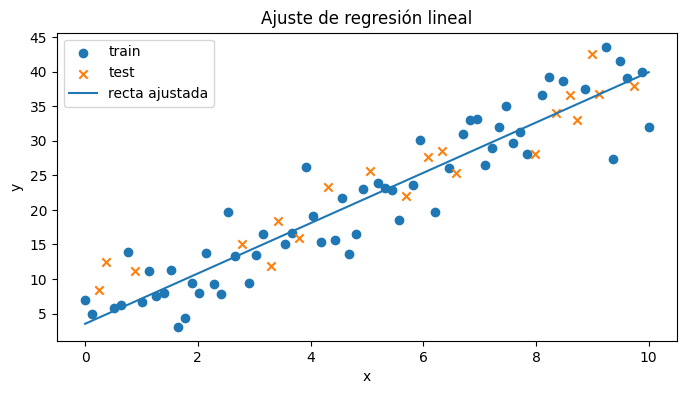

In [ ]:
# Ajuste y métricas
model = LinearRegression()
# train/test split para ejemplo
X_train, X_test, y_train, y_test = train_test_split(X_2d, y, test_size=0.25, random_state=0)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Coeficiente (pendiente) β1 =", model.coef_[0])
print("Intercepto β0 =", model.intercept_)
print("MSE (test) =", mean_squared_error(y_test, y_pred))
print("R² (test) =", r2_score(y_test, y_pred))

# Visualización del ajuste
plt.figure(figsize=(8,4))
plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, label='test', marker='x')
xx = np.linspace(X.min(), X.max(), 100)
plt.plot(xx, model.predict(xx.reshape(-1,1)), label='recta ajustada')
plt.legend()
plt.title("Ajuste de regresión lineal")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## Validación cruzada (k-fold)

La validación k-fold divide los datos en k particiones; se entrena en k-1 y se valida en la restante, repitiendo k veces.
Esto ayuda a estimar mejor el rendimiento fuera de muestra y a reducir la varianza de la estimación.
A continuación calculamos la puntuación (R²) por k-fold.

In [ ]:
# K-fold cross-validation
from sklearn.model_selection import cross_val_score

k = 5
scores = cross_val_score(LinearRegression(), X_2d, y, cv=k, scoring='r2')
print(f"R² por fold (k={k}):", np.round(scores, 4))
print("R² promedio:", np.round(scores.mean(), 4), "±", np.round(scores.std(),4))

R² por fold (k=5): [-0.9174  0.3556  0.2653  0.171  -0.4682]
R² promedio: -0.1187 ± 0.4932


## Discusión final (sesgo vs varianza) y conclusiones

- **Sesgo**: modelos muy simples (poca complejidad) tienden a subestimar la relación (alto sesgo).
- **Varianza**: modelos muy complejos (mucha flexibilidad) pueden ajustarse al ruido (alta varianza).
- La validación cruzada nos ayuda a estimar expectativa de rendimiento en datos no vistos.
- Para tareas reales: limpiar datos, seleccionar características relevantes, normalizar si es necesario, probar varios modelos y usar validación robusta.

## Recursos y lecturas recomendadas

- Scikit-learn documentation: para profundizar en DecisionTreeClassifier, LinearRegression, cross_val_score.